In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



def count(df):
    counts = df.groupby(['label', 'hour']).size().reset_index(name='count')
    df = df.merge(counts, on=['label', 'hour'], how='left')
    return df


#open weather data 2018, read textfile and convert to dataframe
text = open('data/2018_weather_data.txt', 'r')
weather_data = text.read()
weather_data = weather_data.split('\n')
weather_data = [i.split('\t') for i in weather_data[1:]]
weather_data = pd.DataFrame(weather_data)
weather_data.columns = ['Date', 'Max_temp', 'Min_temp', 'Avg_temp', 'Departure_temp', 'HDD', 'CDD', 'Precipitation', 'Snowfall', 'Snow_depth']
weather_data = weather_data.dropna()
# day month
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data['day'] = weather_data['Date'].dt.day
weather_data['month'] = weather_data['Date'].dt.month
weather_data['weekend'] = np.where(weather_data['Date'].dt.dayofweek < 5, 0, 1)
weather_data['day_of_week'] = weather_data['Date'].dt.dayofweek
weather_data['year'] = weather_data['Date'].dt.year
weather_data['day_of_year'] = weather_data['Date'].dt.dayofyear
weather_data.drop(['Date'], axis=1, inplace=True)

weather_data.replace('T', 0, inplace=True)
weather_data.replace('M', 0, inplace=True)

# convert temperatures to celcius
weather_data['Max_temp'] = (weather_data['Max_temp'].astype(float) - 32) * 5/9
weather_data['Min_temp'] = (weather_data['Min_temp'].astype(float) - 32) * 5/9
weather_data['Avg_temp'] = (weather_data['Avg_temp'].astype(float) - 32) * 5/9
weather_data['Departure_temp'] = (weather_data['Departure_temp'].astype(float) - 32) * 5/9


# check for nan
print(weather_data.isnull().sum())

print(weather_data.head())

df = pd.read_csv('data/Trips_2018.csv')
df.rename(columns={'Unnamed: 0': 'trip_id'}, inplace=True)
df.set_index('trip_id', inplace=True)
df = df.dropna()
df['starttime'] = pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime'] = pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
df = df[~np.isnan(df['start_station_id'])]
df = df[~np.isnan(df['end_station_id'])]
# get rid of Canada outlier
df = df[df['start_station_longitude'] < -73.6]
df = df[df['end_station_longitude'] < -73.6]
df = pd.get_dummies(df, columns=['usertype'], dtype=int, drop_first=True)

print(df.columns)
print(df.head())

df_arrival = df.drop(['start_station_latitude', 'start_station_longitude', 'start_station_id', 'starttime'], axis=1)
df_departure = df.drop(['end_station_latitude', 'end_station_longitude', 'end_station_id', 'stoptime'], axis=1)

# make lat and long called that and time
df_arrival.rename(columns={'end_station_latitude': 'latitude', 'end_station_longitude': 'longitude'}, inplace=True)
df_departure.rename(columns={'start_station_latitude': 'latitude', 'start_station_longitude': 'longitude'}, inplace=True)
df_arrival.rename(columns={'stoptime': 'time'}, inplace=True)
df_departure.rename(columns={'starttime': 'time'}, inplace=True)

print(df_arrival.columns)
print(df_departure.columns)

# add hour, day, month, weekend, day of week
df_arrival['hour'] = df_arrival['time'].dt.hour
df_departure['hour'] = df_departure['time'].dt.hour
df_arrival['day'] = df_arrival['time'].dt.day
df_departure['day'] = df_departure['time'].dt.day
df_arrival['month'] = df_arrival['time'].dt.month
df_departure['month'] = df_departure['time'].dt.month
df_arrival['weekend'] = np.where(df_arrival['time'].dt.dayofweek < 5, 0, 1)
df_departure['weekend'] = np.where(df_departure['time'].dt.dayofweek < 5, 0, 1)
df_arrival['day_of_week'] = df_arrival['time'].dt.dayofweek
df_departure['day_of_week'] = df_departure['time'].dt.dayofweek
df_arrival['day_of_year'] = df_arrival['time'].dt.dayofyear
df_departure['day_of_year'] = df_departure['time'].dt.dayofyear

kmeans = KMeans(n_clusters=20, random_state=0, n_init='auto').fit(df_arrival[['latitude', 'longitude']])

# add labels using k means predict
df_arrival['label'] = kmeans.predict(df_arrival[['latitude', 'longitude']])
df_departure['label'] = kmeans.predict(df_departure[['latitude', 'longitude']])




Max_temp          0
Min_temp          0
Avg_temp          0
Departure_temp    0
HDD               0
CDD               0
Precipitation     0
Snowfall          0
Snow_depth        0
day               0
month             0
weekend           0
day_of_week       0
year              0
day_of_year       0
dtype: int64
   Max_temp   Min_temp   Avg_temp  Departure_temp HDD CDD Precipitation   
0 -7.222222 -13.888889 -10.555556      -30.111111  52   0          0.00  \
1 -3.333333 -10.555556  -6.944444      -26.388889  45   0          0.00   
2 -1.111111  -8.888889  -5.000000      -24.333333  42   0          0.00   
3 -1.666667  -7.222222  -4.444444      -23.722222  41   0          0.76   
4 -7.222222 -12.777778 -10.000000      -29.166667  51   0          0.00   

  Snowfall Snow_depth  day  month  weekend  day_of_week  year  day_of_year  
0      0.0          0    1      1        0            0  2018            1  
1      0.0          0    2      1        0            1  2018            2  
2    

In [2]:
# count
df_arrival = count(df_arrival)
df_departure = count(df_departure)
print('added count')

added count


In [3]:
# drop duplicates
df_arrival = df_arrival.drop_duplicates()
df_departure = df_departure.drop_duplicates()

print(df_arrival.head())
print(df_departure.head())


   tripduration                    time  end_station_id   latitude  longitude   
0           970 2018-01-01 14:07:08.186           505.0  40.749013 -73.988484  \
1           723 2018-01-01 15:45:33.341          3255.0  40.750585 -73.994685   
2           496 2018-01-01 15:47:35.172           525.0  40.755942 -74.002116   
3           306 2018-01-01 15:45:20.191           447.0  40.763707 -73.985162   
4           306 2018-01-01 18:19:57.642          3356.0  40.774667 -73.984706   

   bikeid  birth_year  gender  usertype_Subscriber  hour  day  month  weekend   
0   31956        1992       1                    1    14    1      1        0  \
1   32536        1969       1                    1    15    1      1        0   
2   16069        1956       1                    1    15    1      1        0   
3   31781        1974       1                    1    15    1      1        0   
4   30319        1992       1                    1    18    1      1        0   

   day_of_week  day_of_yea

In [4]:
df_departure.columns

Index(['tripduration', 'time', 'start_station_id', 'latitude', 'longitude',
       'bikeid', 'birth_year', 'gender', 'usertype_Subscriber', 'hour', 'day',
       'month', 'weekend', 'day_of_week', 'day_of_year', 'label', 'count'],
      dtype='object')

# Visualizations and data exploration
Firtstly let's examine the the weather data we included and establish which witch features are contributing to the most variance in the data. We will also look at the distribution of the data to see if there are any outliers or other anomalies that we should be aware of.


In [5]:
# calculate average precipitation per day 

weather_temperature_per_day = weather_data[['day_of_year', 'Avg_temp', 'weekend']].groupby(['day_of_year', 'weekend']).mean().reset_index()

df_departure_avg = df_departure[['day_of_year', 'weekend', 'count']].groupby(['day_of_year', 'weekend']).mean().reset_index()
df_arrival_avg = df_arrival[['day_of_year', 'weekend', 'count']].groupby(['day_of_year', 'weekend']).mean().reset_index()


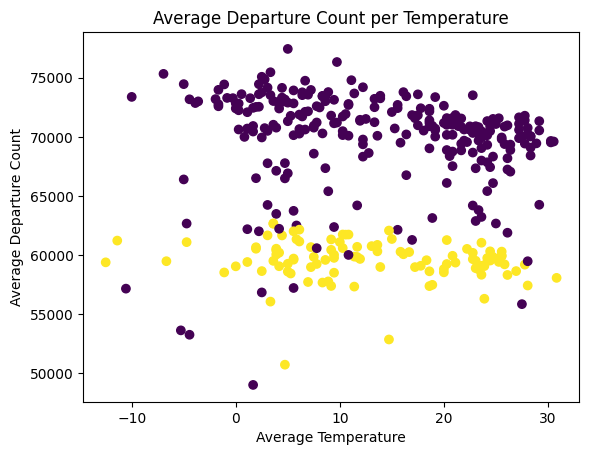

In [6]:
# plot the average deoparture count per temperature make weekend == 0 red and weekend == 1 blue
plt.scatter(weather_temperature_per_day['Avg_temp'], df_departure_avg['count'], c=df_departure_avg['weekend'])
plt.xlabel('Average Temperature')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Temperature')
plt.show()






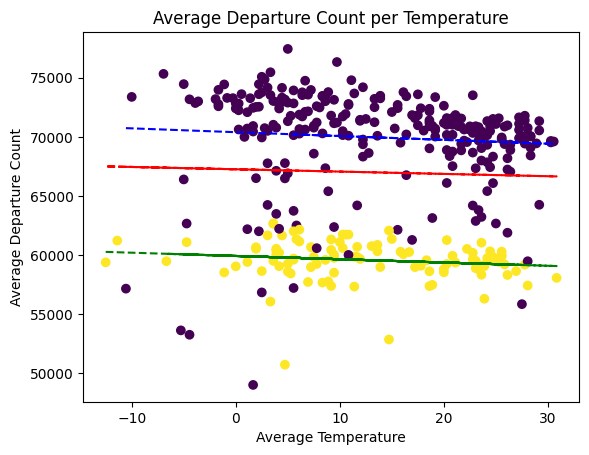

In [7]:
#plot a best fit line for all the data points and then plot 2 separate best fit lines for weekday = 0 and weekday = 1

# get the best fit line for all the data points
z = np.polyfit(weather_temperature_per_day['Avg_temp'], df_departure_avg['count'], 1)
p = np.poly1d(z)
plt.plot(weather_temperature_per_day['Avg_temp'], p(weather_temperature_per_day['Avg_temp']), "r--")

# get the best fit line for weekday = 0
z = np.polyfit(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 0]['Avg_temp'], df_departure_avg[df_departure_avg['weekend'] == 0]['count'], 1)
p = np.poly1d(z)

plt.plot(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 0]['Avg_temp'], p(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 0]['Avg_temp']), "b--")

# get the best fit line for weekday = 1
z = np.polyfit(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 1]['Avg_temp'], df_departure_avg[df_departure_avg['weekend'] == 1]['count'], 1)
p = np.poly1d(z)

plt.plot(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 1]['Avg_temp'], p(weather_temperature_per_day[weather_temperature_per_day['weekend'] == 1]['Avg_temp']), "g--")

plt.scatter(weather_temperature_per_day['Avg_temp'], df_departure_avg['count'], c=df_departure_avg['weekend'])


plt.xlabel('Average Temperature')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Temperature')
plt.show()


In [8]:
# calculate average precipitation per day 

weather_precipitation_per_day = weather_data[['day_of_year', 'Precipitation', 'weekend']]

# convert Precipitation to float

weather_precipitation_per_day['Precipitation'] = weather_precipitation_per_day['Precipitation'].astype(float)
weather_data['Precipitation'] = weather_data['Precipitation'].astype(float)

weather_precipitation_per_day = weather_precipitation_per_day.groupby(['day_of_year', 'weekend']).mean().reset_index()



C:\Users\alexi\AppData\Local\Temp\ipykernel_19412\3808768028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_precipitation_per_day['Precipitation'] = weather_precipitation_per_day['Precipitation'].astype(float)


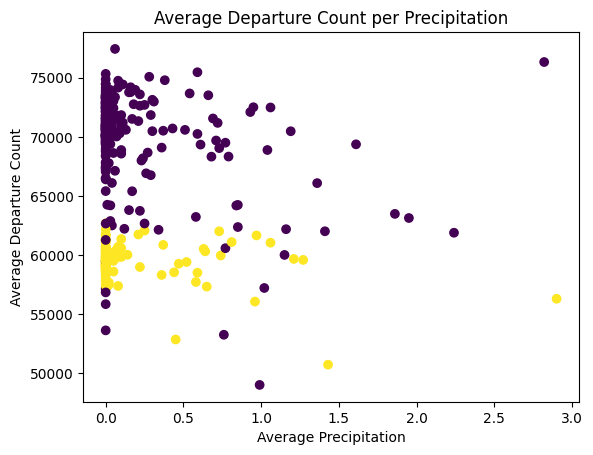

In [9]:
# plot the average Precipitation per day against the average count of departures per day
plt.scatter(weather_precipitation_per_day['Precipitation'], df_departure_avg['count'], c=df_departure_avg['weekend'])
plt.xlabel('Average Precipitation')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Precipitation')
plt.show()

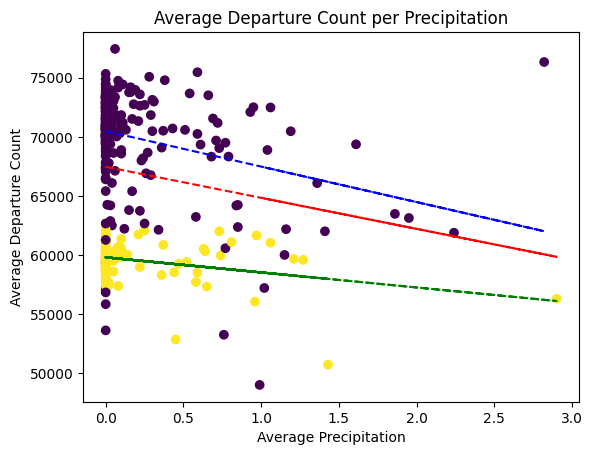

In [10]:
#plot a best fit line for all the data points and then plot 2 separate best fit lines for weekday = 0 and weekday = 1

# get the best fit line for all the data points
z = np.polyfit(weather_precipitation_per_day['Precipitation'], df_departure_avg['count'], 1)
p = np.poly1d(z)
plt.plot(weather_precipitation_per_day['Precipitation'], p(weather_precipitation_per_day['Precipitation']), "r--")

# get the best fit line for weekday = 0
z = np.polyfit(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 0]['Precipitation'], df_departure_avg[df_departure_avg['weekend'] == 0]['count'], 1)
p = np.poly1d(z)

plt.plot(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 0]['Precipitation'], p(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 0]['Precipitation']), "b--")

# get the best fit line for weekday = 1
z = np.polyfit(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 1]['Precipitation'], df_departure_avg[df_departure_avg['weekend'] == 1]['count'], 1)
p = np.poly1d(z)

plt.plot(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 1]['Precipitation'], p(weather_precipitation_per_day[weather_precipitation_per_day['weekend'] == 1]['Precipitation']), "g--")

plt.scatter(weather_precipitation_per_day['Precipitation'], df_departure_avg['count'], c=df_departure_avg['weekend'])


plt.xlabel('Average Precipitation')
plt.ylabel('Average Departure Count')
plt.title('Average Departure Count per Precipitation')
plt.show()




In [11]:
df_arrival.head()

,tripduration,time,end_station_id,latitude,longitude,bikeid,birth_year,gender,usertype_Subscriber,hour,day,month,weekend,day_of_week,day_of_year,label,count
0,970,2018-01-01 14:07:08.186,505.0,40.749013,-73.988484,31956,1992,1,1,14,1,1,0,0,1,10,72203
1,723,2018-01-01 15:45:33.341,3255.0,40.750585,-73.994685,32536,1969,1,1,15,1,1,0,0,1,6,104108
2,496,2018-01-01 15:47:35.172,525.0,40.755942,-74.002116,16069,1956,1,1,15,1,1,0,0,1,6,104108
3,306,2018-01-01 15:45:20.191,447.0,40.763707,-73.985162,31781,1974,1,1,15,1,1,0,0,1,6,104108
4,306,2018-01-01 18:19:57.642,3356.0,40.774667,-73.984706,30319,1992,1,1,18,1,1,0,0,1,1,93289


In [12]:
df_departure.head()

,tripduration,time,start_station_id,latitude,longitude,bikeid,birth_year,gender,usertype_Subscriber,hour,day,month,weekend,day_of_week,day_of_year,label,count
0,970,2018-01-01 13:50:57.434,72.0,40.767272,-73.993929,31956,1992,1,1,13,1,1,0,0,1,6,80956
1,723,2018-01-01 15:33:30.182,72.0,40.767272,-73.993929,32536,1969,1,1,15,1,1,0,0,1,6,88535
2,496,2018-01-01 15:39:18.337,72.0,40.767272,-73.993929,16069,1956,1,1,15,1,1,0,0,1,6,88535
3,306,2018-01-01 15:40:13.372,72.0,40.767272,-73.993929,31781,1974,1,1,15,1,1,0,0,1,6,88535
4,306,2018-01-01 18:14:51.568,72.0,40.767272,-73.993929,30319,1992,1,1,18,1,1,0,0,1,6,161702


In [13]:
weather_data.head()

,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth,day,month,weekend,day_of_week,year,day_of_year
0,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.00,0.0,0,1,1,0,0,2018,1
1,-3.333333,-10.555556,-6.944444,-26.388889,45,0,0.00,0.0,0,2,1,0,1,2018,2
2,-1.111111,-8.888889,-5.000000,-24.333333,42,0,0.00,0.0,0,3,1,0,2,2018,3
3,-1.666667,-7.222222,-4.444444,-23.722222,41,0,0.76,9.8,1,4,1,0,3,2018,4
4,-7.222222,-12.777778,-10.000000,-29.166667,51,0,0.00,0.0,7,5,1,0,4,2018,5


In [14]:
# set index to day of year
weather_data.set_index('day_of_year', inplace=True)
weather_data.head()

# drop duplicates with arrival and departure columns
weather_data.drop(['day', 'month', 'weekend', 'day_of_week', 'year'], axis=1, inplace=True)

In [15]:
df_arrival = df_arrival.merge(weather_data, on='day_of_year', how='left')
df_arrival.head()

,tripduration,time,end_station_id,latitude,longitude,bikeid,birth_year,gender,usertype_Subscriber,hour,...,count,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth
0,970,2018-01-01 14:07:08.186,505.0,40.749013,-73.988484,31956,1992,1,1,14,...,72203,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
1,723,2018-01-01 15:45:33.341,3255.0,40.750585,-73.994685,32536,1969,1,1,15,...,104108,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
2,496,2018-01-01 15:47:35.172,525.0,40.755942,-74.002116,16069,1956,1,1,15,...,104108,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
3,306,2018-01-01 15:45:20.191,447.0,40.763707,-73.985162,31781,1974,1,1,15,...,104108,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
4,306,2018-01-01 18:19:57.642,3356.0,40.774667,-73.984706,30319,1992,1,1,18,...,93289,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0


In [16]:
df_departure = df_departure.merge(weather_data, on='day_of_year', how='left')
df_departure.head()

,tripduration,time,start_station_id,latitude,longitude,bikeid,birth_year,gender,usertype_Subscriber,hour,...,count,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth
0,970,2018-01-01 13:50:57.434,72.0,40.767272,-73.993929,31956,1992,1,1,13,...,80956,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
1,723,2018-01-01 15:33:30.182,72.0,40.767272,-73.993929,32536,1969,1,1,15,...,88535,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
2,496,2018-01-01 15:39:18.337,72.0,40.767272,-73.993929,16069,1956,1,1,15,...,88535,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
3,306,2018-01-01 15:40:13.372,72.0,40.767272,-73.993929,31781,1974,1,1,15,...,88535,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0
4,306,2018-01-01 18:14:51.568,72.0,40.767272,-73.993929,30319,1992,1,1,18,...,161702,-7.222222,-13.888889,-10.555556,-30.111111,52,0,0.0,0.0,0


In [17]:
df_departure.columns

Index(['tripduration', 'time', 'start_station_id', 'latitude', 'longitude',
       'bikeid', 'birth_year', 'gender', 'usertype_Subscriber', 'hour', 'day',
       'month', 'weekend', 'day_of_week', 'day_of_year', 'label', 'count',
       'Max_temp', 'Min_temp', 'Avg_temp', 'Departure_temp', 'HDD', 'CDD',
       'Precipitation', 'Snowfall', 'Snow_depth'],
      dtype='object')

Similar to the code above we create a Ridge model.